# ___Extremely Randomized Trees - Supervised Machine Learning___
---

## ___What are Extremely Randomized Trees?___

_Extra Trees or Extremely Randomized Trees is like Random Forest which aggregates the results of multiple de-correlated decision trees collected in a “forest” to output it’s result, in that it builds multiple trees and splits nodes using random subsets of features, but with two key differences: it does not bootstrap observations (meaning it samples without replacement), and nodes are split on random splits, not best splits. So, in summary, ExtraTrees:_

* _Builds multiple trees with bootstrap = False by default, which means it samples without replacement._
* _Nodes are split based on random splits among a random subset of the features selected at every node._

_In Extra Trees, randomness doesn’t come from bootstrapping of data, but rather comes from the random splits of all observations. Extra Trees can be used both for regression and classification. (Low Variance)_

_The Extra Trees algorithm works by creating a large number of unpruned decision trees from the training dataset. Predictions are made by averaging the prediction of the decision trees in the case of regression or using majority voting in the case of classification._

_As such, there are three main hyperparameters to tune in the algorithm; they are the number of decision trees in the ensemble, the number of input features to randomly select and consider for each split point, and the minimum number of samples required in a node to create a new split point._

___When to choose Extratrees?___ _Extra trees seem to keep a higher performance than Random Forest in presence of noisy features._

## ___Difference between Random Forest and ExtraTrees___

* _Random forest uses bootstrap replicas, that is to say, it subsamples the input data with replacement, whereas Extra Trees use the whole original sample._


* _Another difference is the selection of cut points in order to split nodes. Random Forest chooses the optimum split while Extra Trees chooses it randomly. However, once the split points are selected, the two algorithms choose the best one between all the subset of features. Therefore, Extra Trees adds randomization but still has optimization._

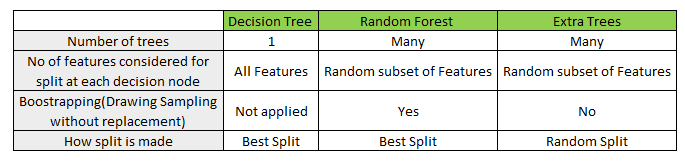

In [1]:
# Packages / libraries

import os #provides functions for interacting with the operating system

import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
import math
from math import sqrt
import random
import time

import warnings
warnings.filterwarnings('ignore')

## ___ExtraTrees Classifier___

_[BNP Paribas Cardif Claims Management - Download Data](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/data)_

In [2]:
## LOADING THE DATA
## training data
train = pd.read_csv(r'C:\Users\PiyushSin\Downloads\BNP\train.csv')
target = train['target'].values
train = train.drop(['ID','target'],axis=1)

## test data (awaiting predictions)
test = pd.read_csv(r'C:\Users\PiyushSin\Downloads\BNP\test.csv')
test_ID = test['ID'].values
test = test.drop(['ID'],axis=1)

train.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,NaN,1.312910,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,1.050328,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [3]:
## DATA PREPARATION
for (train_name, train_series), (test_name, test_series) in zip(train.iteritems(), test.iteritems()):
    if train_series.dtype == 'object':
        ## for objects: factorize
        train[train_name], tmp_indexer = pd.factorize(train[train_name])
        test[test_name] = tmp_indexer.get_indexer(test[test_name])
        ## but now we have -1 values (NaN)
    elif train_series.dtype=='int':
        ## for int: fill in NaN
        ## train data set
        tmp_len = len(train[train_series.isnull()])
        if tmp_len>0:
            train.loc[train_series.isnull(), train_name] = -9999 #fillna
        ## and test
        tmp_len = len(test[test_series.isnull()])
        if tmp_len>0:
            test.loc[test_series.isnull(), test_name] = -9999  #fillna
    else:
        tmp_len = len(train[train_series.isnull()])
        ## for float: fill in series.mean
        ## train data set
        if tmp_len>0:
            #print "mean", train_series.mean()
            train.loc[train_series.isnull(), train_name] = train_series.mean()
        #and test data set
        tmp_len = len(test[test_series.isnull()])
        if tmp_len>0:
            #print "mean", test_series.mean()
            test.loc[test_series.isnull(), test_name] = test_series.mean()

In [4]:
X_train = train
X_test = test

X_train.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,1.335739,8.727474,0,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,...,8.000000,1.989780,0.035754,0,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,1.630686,7.464411,0,4.145098,9.191265,2.436402,2.483921,2.301630,9.031859,1.312910,...,6.822439,3.549938,0.598896,1,1.672658,3.239542,1.957825,0,1.925763,1.739389
2,0.943877,5.310079,0,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,...,9.333333,2.477596,0.013452,2,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,0.797415,8.304757,0,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,...,7.018256,1.812795,0.002267,3,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,1.630686,7.464411,0,4.145098,8.742359,2.436402,2.483921,1.496569,9.031859,1.050328,...,6.822439,3.549938,0.919812,4,1.672658,3.239542,2.030373,0,1.925763,1.739389


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_valdt, y_train, y_valdt = train_test_split(X_train,target,test_size = 0.2, random_state = 24)

In [6]:
from sklearn.ensemble import ExtraTreesClassifier

extrTrClassfr = ExtraTreesClassifier(n_estimators=200,
                                     max_features= 30,
                                     criterion= 'entropy',
                                     min_samples_split= 20,
                                     max_depth= 30,
                                     min_samples_leaf= 2, ## the default is 1 (note we use more than one sample for the split)
                                     n_jobs= -1,
                                     random_state=24)

extrTrClassfr.fit(X_train, y_train)

ExtraTreesClassifier(criterion='entropy', max_depth=30, max_features=30,
                     min_samples_leaf=2, min_samples_split=20, n_estimators=200,
                     n_jobs=-1, random_state=24)

In [7]:
from sklearn.metrics import log_loss

valdt_PredProb = extrTrClassfr.predict_proba(X_valdt)

log_loss = log_loss(y_valdt, valdt_PredProb)
print('\'log_loss\'[validation set]: %.5f' %log_loss)

'log_loss'[validation set]: 0.46439


## ___ExtraTrees Regressor___

_[Mercedes-Benz Greener Manufacturing - Download Data](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/data)_

In [9]:
train = pd.read_csv(r'C:\Users\PiyushSin\Downloads\Mercedes\train.csv')
test = pd.read_csv(r'C:\Users\PiyushSin\Downloads\Mercedes\test.csv')

y_train = train['y'].values
id_test = test['ID']

num_train = len(train)
df_all = pd.concat([train, test])
df_all.drop(['ID', 'y'], axis=1, inplace=True)

# One-hot encoding of categorical/strings
df_all = pd.get_dummies(df_all, drop_first=True)

train = df_all[:num_train]
test = df_all[num_train:]

In [10]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor(n_estimators=100, n_jobs=4, min_samples_split=25,
                            min_samples_leaf=35, max_features=150)

In [12]:
# Parameter Tuning
from sklearn.model_selection import GridSearchCV

gsc = GridSearchCV(
    estimator=model,
    param_grid={
        #'n_estimators': range(50,126,25),
        'max_features': range(50,401,50),
        #'min_samples_leaf': range(20,50,5),
        #'min_samples_split': range(15,36,5),
    },
    scoring='r2',
    cv=5
)

grid_result = gsc.fit(train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.558797 using {'max_features': 150}


In [13]:
# Fitting tuned model

model = ExtraTreesRegressor(**grid_result.best_params_)
model.fit(train, y_train)

ExtraTreesRegressor(max_features=150)

In [14]:
# Prediction 
pd.DataFrame({'ID': id_test, 'y': model.predict(test)})

,ID,y
0,1,76.086450
1,2,96.343250
2,3,76.356100
3,4,76.621100
4,5,111.285650
...,...,...
4204,8410,103.820000
4205,8411,96.637850
4206,8413,94.211267
4207,8414,110.562200
